# Downtown Providence Parking Analysis

This notebook calculates various metrics on the overabbundance of parking in Downtown Providence, RI.

[OSMnx](https://github.com/gboeing/osmnx) is used to download and maniuplate data from [OpenStreetMap](https://www.openstreetmap.org/#map=15/41.8222/-71.4085) (OSM).

In [1]:
import osmnx as ox

## Setup

Specify the area to look for and the type of footprints to look for. Here, we only want the Downtown Neighborhood, and we are only looking for footprints tagged as "amenity:parking" in OSM.

**Note:** You must supply a `place` string which returns a valid result in OSM. For this calculation, I manually had to create the "Dowtown" neighborhood from the [City's GIS](http://pvdgis.maps.arcgis.com/home/webmap/viewer.html?useExisting=1&layers=07555d51a34a4fa0a43e9c920f68970f). Other neighborhoods may or may not be on OSM. For example, Fox Point and College Hill are, but Upper South Providence is not.

In [2]:
place = "Downtown, Providence, RI, USA"
footprint_type = "parking"

Download the footprints from OSM, and them project them to UTM 19 via OSMnx (UTM Zone selected automatically):

In [3]:
footprints_unprojected = ox.footprints.footprints_from_place(place, footprint_type=footprint_type)
footprints = ox.project_gdf(footprints_unprojected)

`footprints_from_place` and `project_gdf` returnn GeoPandas `GeoDataFrame`s. Examine the first few entries of the latter:

In [4]:
footprints.head()

,nodes,amenity,building,capacity,capacity:disabled,name,parking,source,supervised,wikidata,...,addr:state,addr:street,description,fee,building:levels,layer,lit,smoothness,members,type
121498413,"[1359954107, 1359954080, 1359954126, 135995408...",parking,yes,2400,33,Rhode Island Convention Center,multi-storey,Bing,yes,Q7320906,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535719,"[1549239929, 1549239995, 1549239920, 154923986...",parking,yes,NaN,NaN,Biltmore Garage,multi-storey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535724,"[1549239764, 3190088397, 1549239673, 154923959...",parking,yes,NaN,NaN,NaN,multi-storey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535769,"[1549239670, 7105448142, 7105448141, 154923954...",parking,yes,NaN,NaN,NaN,multi-storey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535777,"[1549239863, 7107873191, 1549239787, 154923972...",parking,yes,NaN,NaN,NaN,multi-storey,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And take a look at the geometries (stored as [Shapely Polygons](https://shapely.readthedocs.io/en/stable/manual.html#polygons)).

In [5]:
footprints.geometry.head()

121498413    POLYGON ((299344.171 4633139.476, 299344.231 4...
141535719    POLYGON ((299480.300 4633065.483, 299518.656 4...
141535724    POLYGON ((299920.958 4632965.162, 299927.951 4...
141535769    POLYGON ((299345.605 4632950.568, 299388.869 4...
141535777    POLYGON ((299862.573 4633016.029, 299886.587 4...
Name: geometry, dtype: geometry

And plot these as well, using OSMnx's `plot_footprints` function:

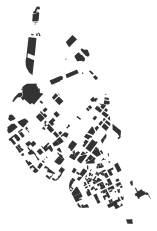

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x118eac990>)

In [6]:
ox.footprints.plot_footprints(footprints)

## Calculations

In [7]:
calculations = {'total': {}}  # Dictionary to hold all useful calculations

Let's get some basic calculations done first:

In [8]:
calculations['total']['count'] = len(footprints.index)
calculations['total']['area_naive'] = footprints.area.sum()  # Areas in square meters

calculations['total']

{'count': 181, 'area_naive': 301352.06851400656}

### Surface Lots

In [9]:
calculations['surface'] = {}

There's a lot of data to work with, and it's important to differentiate between different types of parking areas. For example, the area taken by a surface lot is used much less efficiently than it would by a multi-story lot.

Most of this data separation will be accomplished using the Pandas `query` function. For example, to filter the original footprints to entries that are surface lots:

In [10]:
filtered_surface = footprints.query("parking == 'surface'")
filtered_surface.head()

,nodes,amenity,building,capacity,capacity:disabled,name,parking,source,supervised,wikidata,...,addr:state,addr:street,description,fee,building:levels,layer,lit,smoothness,members,type
146047911,"[1593435262, 1593435285, 1593435350, 159343529...",parking,NaN,NaN,NaN,NaN,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146047918,"[1593435488, 1593435458, 1593435230, 159343549...",parking,NaN,NaN,NaN,NaN,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146047930,"[1593435352, 1593435214, 1593435342, 159343522...",parking,NaN,NaN,NaN,NaN,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146047932,"[1593435493, 1593435452, 1593435400, 159343519...",parking,NaN,NaN,NaN,NaN,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146063025,"[1593531125, 1593531279, 1593530740, 159353102...",parking,NaN,NaN,NaN,NaN,surface,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
calculations['surface']['count'] = len(filtered_surface.index)
calculations['surface']['area'] = filtered_surface.area.sum()

calculations['surface']

{'count': 161, 'area': 200896.37325141992}